## RStan Final Project Workbook

Useful resource: https://mc-stan.org/docs/stan-users-guide/regression.html

## Questions/TO DO:

* Should we model beta for a single gene at a time, and then run this model for each gene?

* Should we standardize our expression levels?

* To do: write code to Analyze $Y$ predictions (expression levels) and perform other diagnostics

The paper which describes the biological phenomenon/experimental problem is:

* Gasperini M, Hill AJ, McFaline-Figueroa JL, et al. (2019) A Genome-wide Framework for Mapping Gene Regulation via Cellular Genetic Screens. Cell 176(1-2):377-390.e19.
doi:10.1016/j.cell.2018.11.029

## The Experiment

* Each cell receives either 0 or 1 guide; a guide ID of -1 denotes no guide inthe cell (control)

* Some guides are functional, and _some are non-functional._ Which guides are functional is _not_ known a priori.

* Each enhancer is targeted by 5 guides, but each cell only gets one guide (or no guide for the control cells).

* The goal is to **estimate the effect size**, $\beta$, of each enhancer on each gene. This estimate should **aggregate information accross the guides** targeting the enhancer.

* A $\beta$ of 1 indicates _no effect_; a $\beta < 1$ means that perturbing the enhancer reduces gene expression by a proporrtion given by $\beta$. Thus, $Y = \beta X$, where $X$ is the control expression level, $\beta$ is the effect size, and $T$ is the treatment expression level when the hancer is perturbed by a _functional_ guide. Remember that nonfunctional guides do _not_ perturb the expression; unfortunately, which guides are functional is not known a priori.

Our goal is to use STAN or JAGS to implement a Bayesian hierarchical model to estimate the $\beta$ values (one for each enhancer-gene pair), aggregating information across the guides targeting an enhancer while accounting for the unknown functional status of individual guides. Run your model on the data and use the true-betas file to evaluate your predictions.

* **This estimate should aggregate information accross the guides targeting the enhancer.**

## To Use on Slurm

#### Create environment

```
conda create stanenv
conda active stanenv
module load R/4.4.0
R
```

Once in R, run `install.packages("rstan")`. Once finished, type `q()` to quit and press `n` so you don't save your environment.


#### Interactive on Biostat

```
srun --account biostat --partition biostat --mem 32GB --cpus-per-task 4 --pty bash -i
conda activate stanenv
module load R/4.4.0
R
```

In R, load `rstan`, or install it if you don't have it.

```
install.packages("rstan")
library("rstan")
```

#### Script for batch files on Biostat Partition

`sbatch rstan_slurm_script.sh`

```
#!/bin/bash
#SBATCH --account=biostat
#SBATCH --partition=biostat
#SBATCH --job-name=stan_job
#SBATCH --time=72:00:00 # 72hrs should be sufficient
#SBATCH --mem=16G  # 16GB is prob enough
#SBATCH --ntasks=1
#SBATCH -o stdout_STAN_%j.stdout.out
#SBATCH -e stderr_STAN_%j.stderr.out
#SBATCH --cpus-per-task=4 # Want four threads

# Load an environement that has rstan in it
source activate stanenv

module load R/4.4.0
export STAN_NUM_THREADS=$SLURM_CPUS_PER_TASK  # if using multi-threading

# Run your R script that calls Stan
Rscript RSTAN.R
```

#### `RSTAN.R` Example

```
# Load rstan library
dat <- read.table("./final/data1.txt", header = TRUE, sep = '\t')

dat <- dat[dat$geneID %in% 1:5,]

dat$gene_enhancer <- paste("( ", dat$geneID, ", ", dat$enhancerID, ")", sep = '')

# Load necessary library
library(rstan)

# Step 1: Load and Normalize Data
# Assuming 'dat' is already loaded as your data frame with columns:
# 'geneID', 'enhancerID', 'guideID', 'cellID', 'expression', 'gene_enhancer'

# Normalize 'expression' to mean 0 and unit variance
dat$expression <- scale(dat$expression, center = TRUE, scale = TRUE)

# Convert 'gene_enhancer' to a factor and then to an integer index
dat$gene_enhancer <- as.factor(dat$gene_enhancer)

# Prepare the data for Stan
stan_data <- list(
  N = nrow(dat),                            # Number of observations
  G = length(unique(dat$gene_enhancer)),    # Number of unique gene_enhancer pairs
  gene_enhancer = as.integer(dat$gene_enhancer),  # Index for gene_enhancer pairs
  expression = as.vector(dat$expression)    # Normalized expression values
)

# Step 2: Write the Stan Model Code
stan_model_code <- "
data {
  int<lower=1> N;                           // Number of observations
  int<lower=1> G;                           // Number of unique gene_enhancer pairs
  int<lower=1, upper=G> gene_enhancer[N];   // Gene-enhancer pair index for each observation
  vector[N] expression;                     // Normalized expression values
}

parameters {
  vector<lower=0, upper=1>[G] beta;         // Beta coefficients for each gene_enhancer pair, constrained to [0, 1]
}

model {
  // Likelihood: Expression modeled as normally distributed around beta[gene_enhancer] with unit variance
  expression ~ normal(beta[gene_enhancer], 1);
}
"

# Step 3: Fit the Model with RStan
# Compile and sample from the model
fit <- stan(model_code = stan_model_code, data = stan_data, iter = 2000, chains = 4)

# Step 4: Review Results
# Print the summary of the beta coefficients
print(fit, pars = "beta")

# Optionally extract and plot results
beta_estimates <- extract(fit)$beta

print(beta_estimates)
```

#### Submitting the Batch Script

```
sbatch rstan_slurm_script.sh
```


## Writeup Notes

# Grading

Each bullet listed below is worth 5 points. If a topic was not addressed, 0 points will be given.

If the topic was addressed fully, 5 points will be given. If the topic was addressed but important details were omitted, partial credit will be given.


### Biological Problem (20 Points)

* Was the biological problem clearly stated?
* Was it clear exactly what type of model (e.g.., Multivariate HMM, Naive Bayes, Bayesian logistic regression, etc.) was applied?
* Was the chosen type of model appropriate for the problem?
* Was the prediction problem clearly stated, in terms of the features (inputs) and the biological prediction goal?

### Data (15 Points)

* Was the data clearly described, in terms of what the data values represent in the biology, and the sample sizes?
* Was it clear whether the data were continuous or discrete (or both), and whether any special accommodations had to be made in the model to allow such data types?
* Was the source of the data (or precisely how it was simulated) clearly identified? Data Pre-processing (10 points)
* Was there a sentence describing data pre-processing (even if it only said that no pre- processing was necessary)?
* Was the chosen pre-processing appropriate for the type of data used?

### Model Description (30 points)

* Was there a figure illustrating the model?
* Was there a figure legend briefly explaining the figure?
* Was the structure of the model clear (i.e., how variables or nodes relate to each other)?
* Was the meaning of each variable or node in the model clear?
* Was there an informed explanation of why this model should be applicable to this problem?
* Was a baseline model described?

### Training and Inference (15 Points)

* Was the training/inference method clearly identified?
* Was the chosen training/inference method appropriate for the type of model used?
* Were inference parameters (such as numbers of iterations, etc.) described?

### Model Evaluation (15 Points)

* Was there a clear explanation of how the model was evaluated for accuracy/fit?
* Was the evaluation method appropriate for the model?
* Was the evaluation method appropriate for the type of data and the prediction task?

### Results (10 Points)

* Was there a clearly written results section included in the report?
* If the model worked, was there a clear description of the accuracy/fit of the model, including a clearly labeled figure?
  * If the model did not work, did the team attempt to diagnose and fix the problems, and was the accuracy of the alternate method provided (in Figure 2 and the text)?

### Conclusions and Future Directions (10 Points)

* Was there a conclusion section that adequately interpreted the results and their significance for the biological problem being addressed?
* Were some plausible future directions proposed?

### Penalties (written report only)

* Were there more or fewer than 2 figures? **(-5 points)**
* Was the model inappropriately trained and tested on the same data set (applicable only to models having a dedicated training phase), or was the model provided the true answer as an input? **(-5 points)**

### Final Presentation

* The team will present the model and the results during a 10-to-15-minute presentation near the end of the semester. Clearly describe the biological problem, the model, and the results, including any problems you encountered and what you did to try to diagnose and correct any difficulties. (10 points)


#### Mount Google Drive, Define Root Directory (Not worth the time to do the security check, just drag and drop)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#root_dir = "/content/drive/MyDrive/BIOSTATS914/"

Mounted at /content/drive


#### Install that RMagic

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
install.packages("rstan")#, repos = "https://cloud.r-project.org/", dependencies = TRUE)


	‘/tmp/RtmpWHOizn/downloaded_packages’



## Loading Data

* `geneID` - identifier

* `enhancerID` - a putative enhancer being targeted by CRISPR; -1 means no targeting (control)

* `guideID` - A guide RNA targeting this enhancer; -1 means no targeting (control)

* `cellID` - The cell receiving the guide

* `expression` - the measured expression level for this gene in this cell.

In [17]:
%%R
library(rstan)

data <- read.csv("./data1.txt", header = T, sep = '\t')

results <- read.csv("./true-betas1.txt", header = T, sep = '\t')

## Checks

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0700  0.6300  0.9100  0.8089  1.0000  1.0000 


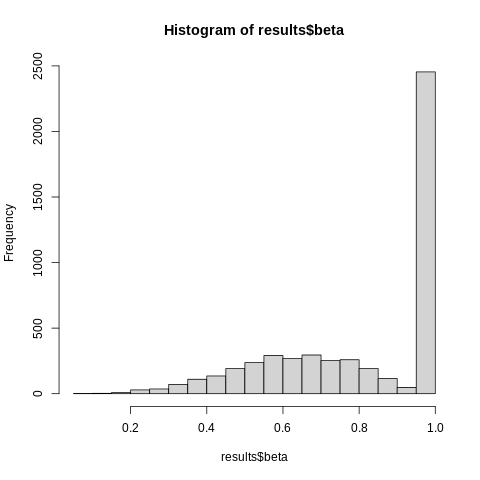

In [18]:
%%R
hist(results$beta)
summary(results$beta)

In [19]:
%%R
head(results)

  geneID enhancerID beta
1      1          1 0.88
2      1          2 0.59
3      1          3 0.39
4      1          4 0.70
5      1          5 0.32
6      2          6 1.00


In [20]:
%%R
head(table(data$geneID[1:500], data$enhancerID[1:500]))

   
     -1   1   2   3   4
  1  30 150 150 150  20


## Pre-Processing

1. Combine Gene-Enhancer Pairs

2. **Transform Expression to Standard Normal!!!**

## Baseline Model (Gene-EnhancerID pairs)

In [12]:
%%R
data <- read.csv("./data1.txt", header = T, sep = '\t')

results <- read.csv("./true-betas1.txt", header = T, sep = '\t')

data$geneID <- NULL
data$enhancerID <- NULL

data$gene_enhancer <- as.integer(factor(data$gene_enhancer))

## Subset
data <- data[data$gene_enhancer %in% c(1:20),]
print(nrow(data))

# Scale
# data$expression <- scale(data$expression)

head(data)

# Prepare the data list for Stan
stan_data <- list(
  N = nrow(data),
  K = length(unique(data$gene_enhancer)),
  gene_enhancer = data$gene_enhancer,
  expression = data$expression
)

[1] 2520


In [34]:
%%R
summary(data$expression)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    109   10550   21148   23205   34218  116665 


## Developing Negative-Control Informed Baseline Method

In [50]:
%%R
# Load data
dat <- read.csv("./data1.txt", header = T, sep = '\t')

# Center and scale the 'expression' column to have mean 0 and unit variance
dat$expression <- scale(dat$expression)
# Merge Genes to Enhancers
dat$gene_enhancer <- paste(dat$geneID, dat$enhancerID, sep = ",")
# Convert 'gene_enhancer' to a factor and then to integer indices
dat$gene_enhancer <- as.integer(as.factor(dat$gene_enhancer))


# Subset
dat <- dat[dat$gene_enhancer %in% c(1:10),]
print(nrow(dat))

# Create a binary indicator for control samples (1 if enhancerID == -1, 0 otherwise)
dat$is_control <- ifelse(dat$enhancerID == -1, 1, 0)

# Prepare data list for Stan
stan_data <- list(
    N = nrow(dat),
    K = length(unique(dat$gene_enhancer)),
    expression = as.vector(dat$expression),
    gene_enhancer = dat$gene_enhancer,
    is_control = dat$is_control
)

[1] 1260


In [51]:
%%R
stan_code <- "
data {
    int<lower=0> N;                       // Total number of observations
    int<lower=1> K;                       // Number of unique gene_enhancer combinations
    vector[N] expression;                  // Normalized expression data
    int<lower=1, upper=K> gene_enhancer[N]; // Index for gene_enhancer
    int<lower=0, upper=1> is_control[N];   // Indicator for control samples
}

parameters {
    real mu_control;
    real mu_noncontrol;
    vector<lower=0, upper=1>[K] beta;
    real<lower=0> sigma; // Shared standard deviation for expression
}
model {
    // Priors
    mu_control ~ normal(0, 1);
    mu_noncontrol ~ normal(0, 1);
    beta ~ beta(2, 2);
    sigma ~ cauchy(0, 2); // Prior for standard deviation

    // Likelihood
    for (i in 1:N) {
        if (is_control[i] == 1) {
            expression[i] ~ normal(mu_control, sigma);
        } else {
            expression[i] ~ normal(mu_noncontrol*beta[gene_enhancer[i]], sigma);
        }
    }
}
"

# Compile and fit the model
fit <- stan(
  model_code = stan_code,
  data = stan_data,
  iter = 2000,
  chains = 1,
  diagnostic_file = "diagnostics.csv"
)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001522 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 15.22 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 7.62 seconds (Warm-up)
Chain 1:                3.482 seconds (Sampling)
Chain 1:                11.

In [52]:
%%R
# Print summary of the results
print(fit, pars = c("beta"))

Inference for Stan model: anon_model.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

         mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
beta[1]  0.51    0.01 0.22 0.10 0.34 0.52 0.70  0.90  1537    1
beta[2]  0.31    0.00 0.06 0.20 0.27 0.30 0.34  0.44   648    1
beta[3]  0.29    0.00 0.05 0.19 0.26 0.29 0.33  0.41   708    1
beta[4]  0.60    0.00 0.08 0.44 0.55 0.60 0.65  0.75   481    1
beta[5]  0.36    0.00 0.06 0.24 0.32 0.36 0.40  0.49   652    1
beta[6]  0.87    0.00 0.08 0.69 0.82 0.88 0.93  0.98   403    1
beta[7]  0.52    0.01 0.22 0.11 0.35 0.52 0.68  0.89  1621    1
beta[8]  0.01    0.00 0.01 0.00 0.00 0.01 0.01  0.02  1493    1
beta[9]  0.01    0.00 0.01 0.00 0.00 0.01 0.01  0.02  1476    1
beta[10] 0.01    0.00 0.01 0.00 0.01 0.01 0.02  0.03  1781    1

Samples were drawn using NUTS(diag_e) at Fri Nov 15 02:14:14 2024.
For each parameter, n_eff is a crude measure of effective sample size,
a

In [53]:
!head -n 10 true-betas1.txt

geneID	enhancerID	beta
1	1	0.88
1	2	0.59
1	3	0.39
1	4	0.7
1	5	0.32
2	6	1
2	7	0.38
2	8	1
2	9	0.77


In [54]:
%%R
# Extract the beta samples
beta_samples <- extract(fit, pars = "beta")$beta

# Summary statistics for beta coefficients
beta_summary <- summary(fit, pars = "beta")$summary
print(beta_summary)

                mean      se_mean          sd         2.5%         25%
beta[1]  0.512744944 0.0056248432 0.220524326 0.0959242407 0.337750115
beta[2]  0.308764927 0.0023222114 0.059125352 0.2010245539 0.266212432
beta[3]  0.292365434 0.0020517766 0.054611255 0.1901794658 0.255553349
beta[4]  0.597213061 0.0036038597 0.079072596 0.4430396249 0.546054066
beta[5]  0.361834121 0.0024626088 0.062882349 0.2432350801 0.316632343
beta[6]  0.869202284 0.0039796937 0.079873592 0.6876498337 0.821218479
beta[7]  0.516053548 0.0054036925 0.217530322 0.1091162188 0.352254324
beta[8]  0.007109176 0.0001354653 0.005234564 0.0009288877 0.003351661
beta[9]  0.007486208 0.0001377528 0.005292122 0.0008009336 0.003604359
beta[10] 0.011161601 0.0001850719 0.007809639 0.0013127171 0.005456247
                 50%         75%      97.5%     n_eff      Rhat
beta[1]  0.515997817 0.695520109 0.89581009 1537.0648 0.9998656
beta[2]  0.304704759 0.343829356 0.43837871  648.2522 0.9989996
beta[3]  0.289649315 0.3264

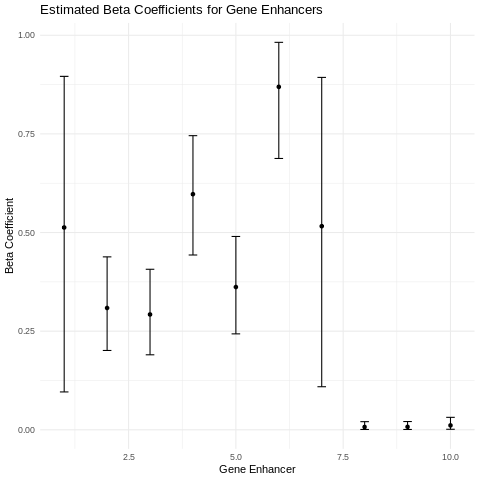

In [55]:
%%R
# Convert to a data frame for easier plotting
beta_df <- as.data.frame(beta_summary)
beta_df$gene_enhancer <- 1:nrow(beta_df)

# Plot with ggplot2
library(ggplot2)
ggplot(beta_df, aes(x = gene_enhancer, y = mean)) +
    geom_point() +
    geom_errorbar(aes(ymin = `2.5%`, ymax = `97.5%`), width = 0.2) +
    labs(title = "Estimated Beta Coefficients for Gene Enhancers",
         x = "Gene Enhancer", y = "Beta Coefficient") +
    theme_minimal()

In [56]:
%%R
# Extract posterior samples
mu_control_samples <- extract(fit, pars = "mu_control")$mu_control
mu_noncontrol_samples <- extract(fit, pars = "mu_noncontrol")$mu_noncontrol
beta_samples <- extract(fit, pars = "beta")$beta


# Mean estimates for each parameter
mu_control_mean <- mean(mu_control_samples)
mu_noncontrol_mean <- mean(mu_noncontrol_samples)
beta_mean <- colMeans(beta_samples)

# Predicted values
dat$predicted_expression <- ifelse(dat$is_control == 1,
                                   mu_control_mean,
                                   mu_noncontrol_mean*beta_mean[dat$gene_enhancer])

In [57]:
%%R
head(dat)

  geneID enhancerID guideID cellID expression gene_enhancer is_control
1      1         -1      -1      1  0.1677894             1          1
2      1         -1      -1      2 -0.2502963             1          1
3      1         -1      -1      3 -0.3803455             1          1
4      1         -1      -1      4  0.4139844             1          1
5      1         -1      -1      5 -0.3588346             1          1
6      1         -1      -1      6 -0.2493126             1          1
  predicted_expression
1            0.1835848
2            0.1835848
3            0.1835848
4            0.1835848
5            0.1835848
6            0.1835848


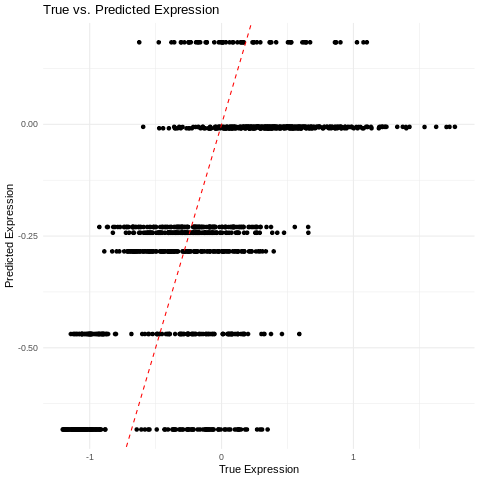

In [58]:
%%R
library(ggplot2)
ggplot(dat, aes(x = expression, y = predicted_expression)) +
    geom_point() +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
    labs(title = "True vs. Predicted Expression",
         x = "True Expression",
         y = "Predicted Expression") +
    theme_minimal()

In [59]:
%%R
# Mean Squared Error
mse <- mean((dat$expression - dat$predicted_expression)^2)

# Mean Absolute Error
mae <- mean(abs(dat$expression - dat$predicted_expression))

cat("Mean Squared Error (MSE):", mse, "\n")
cat("Mean Absolute Error (MAE):", mae, "\n")

Mean Squared Error (MSE): 0.2062131 
Mean Absolute Error (MAE): 0.3658161 


## NEXT MODEL

---

#### Inv_gamma prior

In [ ]:
%%R
data <- read.csv("./data1.txt", header = T, sep = '\t')

results <- read.csv("./true-betas1.txt", header = T, sep = '\t')

data$gene_enhancer <- paste(data$geneID, data$enhancerID, sep = ",")
data$geneID <- NULL
data$enhancerID <- NULL

data$gene_enhancer <- as.integer(factor(data$gene_enhancer))

## Subset
data <- data[data$gene_enhancer %in% c(1:20),]
print(nrow(data))

# Scale
# data$expression <- scale(data$expression)

head(data)

# Prepare the data list for Stan
stan_data <- list(
  N = nrow(data),
  K = length(unique(data$gene_enhancer)),
  gene_enhancer = data$gene_enhancer,
  expression = data$expression
)

In [16]:
%%R
# Define the Stan model with inverse gamma prior as a character string
stan_code <- "
data {
  int<lower=1> N; // Number of observations
  int<lower=1> K; // Number of unique gene_enhancer values
  int<lower=1, upper=K> gene_enhancer[N]; // Gene enhancer group for each observation
  real expression[N]; // Expression values
}

parameters {
  real mu; // Overall mean expression
  real<lower=0> sigma_sq; // Variance parameter for inverse gamma
  real<lower=0, upper=1> beta[K]; // Beta coefficients for each gene enhancer
}

transformed parameters {
  real<lower=0> sigma;
  sigma = sqrt(sigma_sq); // Standard deviation from variance
}

model {
  // Prior distributions-- the model is sensitive to adjusting these
  mu ~ normal(0, 10);
  sigma_sq ~ inv_gamma(1, 1); // Inverse gamma prior on variance (sigma^2)
  beta ~ normal(0.5, 5); // Centered around 0

  // Likelihood
  for (n in 1:N) {
    expression[n] ~ normal(mu * beta[gene_enhancer[n]], sigma);
  }
}
"

# Compile and fit the model
fit <- stan(
  model_code = stan_code,
  data = stan_data,
  iter = 2000,
  chains = 1,
  diagnostic_file = "diagnostics.csv"
)

# Print summary of the results
print(fit, pars = c("mu", "beta", "sigma"))


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000548 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 5.48 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 16.296 seconds (Warm-up)
Chain 1:                4.548 seconds (Sampling)
Chain 1:                20

In [ ]:
%%R
# test <- extract(fit)$beta

NULL


In [ ]:
!head -n 30 diagnostics.csv

# Sample generated by Stan
# stan_version_major=2
# stan_version_minor=32
# stan_version_patch=2
# init=random
# enable_random_init=1
# seed=218288945
# chain_id=1
# iter=2000
# warmup=1000
# save_warmup=1
# thin=1
# refresh=200
# stepsize=1
# stepsize_jitter=0
# adapt_engaged=1
# adapt_gamma=0.05
# adapt_delta=0.8
# adapt_kappa=0.75
# adapt_t0=10
# max_treedepth=10
# sampler_t=NUTS(diag_e)
# diagnostic_file=diagnostics.csv
# append_samples=0
#
lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma_sq,beta.1,beta.2,beta.3,beta.4,beta.5,beta.6,beta.7,beta.8,beta.9,beta.10,beta.11,beta.12,beta.13,beta.14,beta.15,beta.16,beta.17,beta.18,beta.19,beta.20,p_mu,p_sigma_sq,p_beta.1,p_beta.2,p_beta.3,p_beta.4,p_beta.5,p_beta.6,p_beta.7,p_beta.8,p_beta.9,p_beta.10,p_beta.11,p_beta.12,p_beta.13,p_beta.14,p_beta.15,p_beta.16,p_beta.17,p_beta.18,p_beta.19,p_beta.20,g_mu,g_sigma_sq,g_beta.1,g_beta.2,g_beta.3,g_beta.4,g_beta.5,g_beta.6,g_beta.7,g_beta.8,g_beta.9,g_beta.1

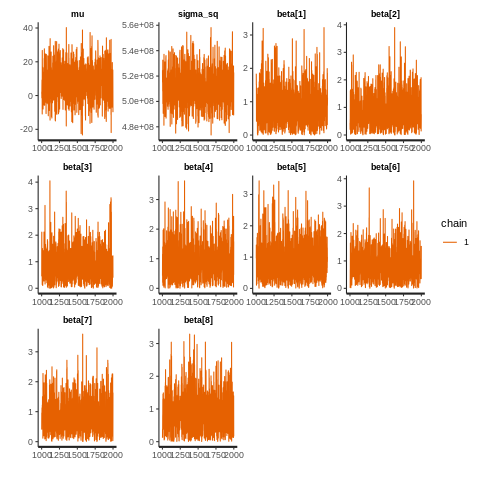

In [ ]:
%%R
traceplot(fit)

In [ ]:
%%R
summary(fit)$summary[, "Rhat"]

       mu  sigma_sq   beta[1]   beta[2]   beta[3]   beta[4]   beta[5]   beta[6] 
0.9998614 0.9990223 1.0003778 1.0021742 0.9991140 0.9991096 0.9990000 0.9990164 
  beta[7]   beta[8]   beta[9]  beta[10]  beta[11]  beta[12]  beta[13]  beta[14] 
0.9990170 0.9994098 0.9991586 1.0043132 0.9990714 0.9992209 1.0015054 0.9994516 
 beta[15]  beta[16]  beta[17]  beta[18]  beta[19]  beta[20]     sigma      lp__ 
0.9995886 0.9991188 0.9999057 1.0015170 0.9995580 1.0005872 0.9990264 1.0060299 


# NEXT We want to aggregate information accross the guides, $Z$(?) targeting the enhancer.

* Each cell receives either 0 or 1 guide; a guide ID of -1 denotes no guide inthe cell (control)

* Some guides are functional, and _some are non-functional._ Which guides are functional is _not_ known a priori.

* Each enhancer is targeted by 5 guides, but each cell only gets one guide (or no guide for the control cells).

* The goal is to **estimate the effect size**, $\beta$, of each enhancer on each gene. This estimate should **aggregate information accross the guides** targeting the enhancer.

* A $\beta$ of 1 indicates _no effect_; a $\beta < 1$ means that perturbing the enhancer reduces gene expression by a proporrtion given by $\beta$. Thus, $Y = \beta X$, where $X$ is the control expression level, $\beta$ is the effect size, and $T$ is the treatment expression level when the hancer is perturbed by a _functional_ guide. Remember that nonfunctional guides do _not_ perturb the expression; unfortunately, which guides are functional is not known a priori.

Our goal is to use STAN or JAGS to implement a Bayesian hierarchical model to estimate the $\beta$ values (one for each enhancer-gene pair), aggregating information across the guides targeting an enhancer while accounting for the unknown functional status of individual guides. Run your model on the data and use the true-betas file to evaluate your predictions.

* **This estimate should aggregate information accross the guides targeting the enhancer.**

In [ ]:
%%R
# Load the data
data <- read.table("./data1.txt", sep = '\t', header = TRUE)

data$gene_enhancer <- paste(data$geneID, data$enhancerID, sep = ",")

# Encode gene_enhancer and guideID as integer indices
data$gene_enhancer <- as.integer(as.factor(data$gene_enhancer))
data$guideID <- as.integer(as.factor(data$guideID))

# data <- data[data$gene_enhancer %in% c(1:20),]
print(nrow(data))

# Prepare data list for Stan
stan_data <- list(
  N = nrow(data),                       # Number of observations
  K = length(unique(data$gene_enhancer)),# Number of unique gene_enhancer values
  G = length(unique(data$guideID)),      # Number of unique guideIDs
  gene_enhancer = data$gene_enhancer,    # Gene enhancer group for each observation
  guideID = data$guideID,                # Guide ID for each observation
  expression = data$expression           # Expression values
)

[1] 780000


In [ ]:
%%R
table(data$gene_enhancer[1:1000])


  1   2   3   4   5   6 673 675 676 
 30 150 150 150 150 150  30 150  40 


In [ ]:
%%R
head(data)

  geneID enhancerID guideID cellID expression gene_enhancer
1      1         -1       1      1      25763             1
2      1         -1       1      2      19388             1
3      1         -1       1      3      17405             1
4      1         -1       1      4      29517             1
5      1         -1       1      5      17733             1
6      1         -1       1      6      19403             1


In [ ]:
%%R
# Define the Stan model as a character string
stan_code <- "
data {
  int<lower=1> N; // Number of observations
  int<lower=1> K; // Number of unique gene_enhancer values
  int<lower=1> G; // Number of unique guideIDs
  int<lower=1, upper=K> gene_enhancer[N]; // Gene enhancer group for each observation
  int<lower=1, upper=G> guideID[N]; // Guide ID for each observation
  real<lower=0> expression[N]; // Expression values
}

parameters {
  real mu; // Overall mean expression
  real<lower=0> sigma_sq; // Variance parameter for inverse gamma
  real<lower=0> beta[K]; // Beta coefficients for each gene enhancer
  real<lower=0, upper=1> theta; // Probability that a guide is functional
}

transformed parameters {
  real<lower=0> sigma;
  sigma = sqrt(sigma_sq); // Standard deviation from variance
}

model {
  // Priors
  mu ~ normal(1, 10);
  sigma_sq ~ inv_gamma(1, 1);
  beta ~ normal(1, 1);
  theta ~ beta(2, 2); // Prior on probability of a guide being functional

  // Likelihood
  for (n in 1:N) {
    target += log_mix(theta,
                      normal_lpdf(expression[n] | mu * beta[gene_enhancer[n]], sigma),
                      normal_lpdf(expression[n] | mu, sigma));
  }
}
"

# Compile and fit the model
fit <- stan(
  model_code = stan_code,
  data = stan_data,
  iter = 2000,
  chains = 1
)

# Print summary of the results
print(fit, pars = c("mu", "beta", "sigma", "theta", "z"))


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.3885 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 13885 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)


## Update: Transitioned to DCC and SLURM

# Graphical Models for Biological Data : Final Project

- Fall 2024
- Authors: jtm98, Ned Ed Neddy

In [ ]:
!install_cmdstan

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.35.0
Download successful, file: /tmp/tmptwaim3j4
Extracting distribution
Unpacked download as cmdstan-2.35.0
Building version cmdstan-2.35.0, may take several minutes, depending on your system.
Installed cmdstan-2.35.0
Test model compilation



# Model 0: Naive Estimator

Where $i$ is a `gene-enhancer` pair.

$$ Y_i \sim X_i * \beta_{i} $$

$$\beta \sim X_{experiment} / X_{control} $$


Naively, one can estimate $\beta$ for a gene-enhancer by dividing the average experiment expression by the average control expression.


In [ ]:
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

# Model 1: Massaging Gaussian Mixture Model

jtm98
Created: 10.29.24

$$ X_i \sim r N (\mu,\sigma^2) + (1-r) N (\beta*\mu,\sigma^2) $$

- $X_i$ is cell expression
- $r$ is a mixture proportion of label $Z_i$
- $Z_i \in {0,1} $ and represents whether a cell had normal (0) or decreased (1)  expression
- $\mu$ is the mean of individuals w/normal expression
- $\beta$ is the enhancer coefficient

### Description:

This is a mixture moel that assumes the expression data come from two normal distributions-- the control distribution $N(\mu, \sigma^2)$ or the enhancer distribution $N(\beta*\mu, \sigma^2)$.


In [ ]:
mixture ="""
// Assessing if beta parameter is inferable
data {
int<lower=1> N; // number of samples
array[N] real X; // expression in the sample
}

parameters {
real<lower=0,upper=1> r; // mixture proportion of samples
real<lower=0.0> sigma; // standard deviation
real mu; // mean of individuals w/ normal expression
real beta; // enhancer coefficient
}

model {
r ~ beta(2,2); // mixture proportion based on natural scale
mu ~ normal(0,10);
beta ~ beta(2,2); // enhancer coefificent should be [0,1]
sigma ~ inv_gamma(1,1);
for(i in 1:N)
target+= log_sum_exp(log(r)+normal_lpdf(X[i]|mu,sigma),
log(1-r)+normal_lpdf(X[i]|beta*mu,sigma));
}

generated quantities {
array[N] real<lower=0,upper=1> PZi;
for(i in 1:N) {
real LP0=log(r)+normal_lpdf(X[i]|mu,sigma);
real LP1=log(1-r)+normal_lpdf(X[i]|beta*mu,sigma);
PZi[i]=exp(LP0-log_sum_exp(LP0,LP1));
}
}
"""
! mkdir mixture
with open('mixture/mixture.stan', 'w') as f: f.write(mixture)
! cat mixture/mixture.stan


// Assessing if beta parameter is inferable
data {
int<lower=1> N; // number of samples
array[N] real X; // expression in the sample
}

parameters {
real<lower=0,upper=1> r; // mixture proportion of samples
real<lower=0.0> sigma; // standard deviation
real mu; // mean of individuals w/ normal expression
real beta; // enhancer coefficient
}

model {
r ~ beta(2,2); // mixture proportion based on natural scale
mu ~ normal(0,10);
beta ~ beta(2,2); // enhancer coefificent should be [0,1]
sigma ~ inv_gamma(1,1);
for(i in 1:N)
target+= log_sum_exp(log(r)+normal_lpdf(X[i]|mu,sigma),
log(1-r)+normal_lpdf(X[i]|beta*mu,sigma));
}

generated quantities {
array[N] real<lower=0,upper=1> PZi;
for(i in 1:N) {
real LP0=log(r)+normal_lpdf(X[i]|mu,sigma);
real LP1=log(1-r)+normal_lpdf(X[i]|beta*mu,sigma);
PZi[i]=exp(LP0-log_sum_exp(LP0,LP1));
}
}


In [ ]:
import pandas as pd

# Load the data
data = pd.read_csv("data1.txt", sep="\t")

data = data.head(2400)

# Prepare the data for Stan
stan_data = {
    "N": len(data),
    "X": data["expression"].values
}

In [ ]:
# Compile the model
model = CmdStanModel(stan_file="mixture/mixture.stan")

# Fit the model
fit = model.sample(data=stan_data, iter_warmup=50, iter_sampling=1000, chains=4)

# Print summary of results
print(fit.summary())

# Access generated quantities
pzi = fit.stan_variable("PZi")

16:28:17 - cmdstanpy - INFO - compiling stan file /content/mixture/mixture.stan to exe file /content/mixture/mixture
INFO:cmdstanpy:compiling stan file /content/mixture/mixture.stan to exe file /content/mixture/mixture
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=mixture.stan /content/mixture/mixture
cwd: /root/.cmdstan/cmdstan-2.35.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=mixture.stan --o=/content/mixture/mixture.hpp /content/mixture/mixture.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISAB

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/mixture/mixture', 'id=1', 'random', 'seed=73242', 'data', 'file=/tmp/tmpxfta993i/82y59e_w.json', 'output', 'file=/tmp/tmpxfta993i/mixture46ctwnlx/mixture-20241113162831_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/mixture/mixture', 'id=2', 'random', 'seed=73242', 'data', 'file=/tmp/tmpxfta993i/82y59e_w.json', 'output', 'file=/tmp/tmpxfta993i/mixture46ctwnlx/mixture-20241113162831_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']


# Model 2: Hierarchical Mixture Model

Updated: 11.09.24


$$ X_i \sim r N (\mu,\sigma^2) + (1-r) N (\beta_{enhancer}*\mu,\sigma^2) $$

- $X_i$ is cell expression
- $r$ is a mixture proportion of label $Z_i$
- $Z_i \in {0,1} $ and represents whether a cell had non-functional (0) or functional (1) guide
- $\mu$ is the mean of individuals w/normal expression
- $\beta$ is the enhancer coefficient

In [ ]:
# Model 0: Naive Estimator with no guide effect
# Model 1: Mixture
# Model 2: Mixture with guide potency and empirical priors
# Model 3: Mixture with guide functionality generated quantities
# Model 4: Pooled mixtured

stan_code ="""
data {
  int<lower=0> N_control;                   // Number of control samples
  int<lower=0> N_experiment;                // Number of experimental samples
  int<lower=0> N_enhancers;                 // Number of enhancers
  int<lower=0> N_guides;                     // Number of guides
  array[N_control] real<lower=0> y_control;  // Expression levels in control samples
  array[N_experiment] real<lower=0> y_experiment;   // Expression levels in experimental samples
  array[N_experiment] int<lower=1> guide;  // Guide index for each experiment sample (1 to 5)
  array[N_experiment] int<lower=1> enhancer; // Enhancer index for each experiment sample (1 to 5)
}

transformed data {
  real<lower=0> mu_control_observed = mean(y_control);            // Empirical mean of y_control
  real<lower=0> sigma_control_observed = sd(y_control);           // Empirical standard deviation of y_control
  real<lower=0> mu_experiment_observed = mean(y_experiment);      // Empirical mean of y_experiment
  real<lower=0> sigma_experiment_observed = sd(y_experiment);     // Empirical standard deviation of y_experiment
  real beta_observed = mu_experiment_observed / mu_control_observed;  // Empirical effect size
}

parameters {
  real<lower=0> mu_control;                 // Mean expression in control condition
  array[N_enhancers] real<lower=0, upper=1> B;        // Effect sizes for each enhancer
  real<lower=0, upper=10000> sigma_control; // Standard deviation in control condition
  real<lower=0, upper=10000> sigma_experiment; // Standard deviation in experiment condition
  array[N_guides] real<lower=0, upper=1> potency;  // Potency for each guide (0 to 1)
}

transformed parameters {
  array[N_enhancers] real<lower=0> mu_experiment;     // Expression levels for each enhancer

  for (e in 1:N_enhancers) {
    mu_experiment[e] = B[e] * mu_control;   // Calculate experiment mean for each enhancer
  }
}

model {
  // Priors based on provided initial values
  mu_control ~ normal(mu_control_observed, sigma_control_observed);
  B ~ beta(0.5, 0.5);                      // Priors for each enhancer effect size
  sigma_control ~ cauchy(sigma_control_observed, 2);
  sigma_experiment ~ cauchy(sigma_experiment_observed, 2);
  potency ~ beta(0.5, 0.5);                // Prior for potency of each guide

  // Likelihoods
  y_control ~ normal(mu_control, sigma_control); // Control samples from control distribution

  for (n in 1:N_experiment) {
    real mean_expr = (1 - potency[guide[n]]) * mu_control + potency[guide[n]] * mu_experiment[enhancer[n]];
    y_experiment[n] ~ normal(mean_expr, sigma_experiment);
  }
}

/*
generated quantities {
  array[N_guides] int<lower=0, upper=1> guide_functionality;

  for (g in 1:N_guides) {
    real log_nonfunctional = 0;
    real log_functional = 0;

    for (n in 1:N_experiment) {
      if (guide[n] == g) {
        log_nonfunctional += log1m(potency[g]) + normal_lpdf(y_experiment[n] | mu_control, sigma_control);
        log_functional += log(potency[g]) + normal_lpdf(y_experiment[n] | mu_experiment[enhancer[n]], sigma_experiment);
      }
    }
    guide_functionality[g] = log_functional > log_nonfunctional ? 1 : 0;
  }
}
*/

"""
name = 'model4_pooled'
! mkdir {name}
with open('%s/%s.stan'%(name,name), 'w') as f: f.write(stan_code)
! cat {name}/{name}.stan

In [ ]:
model = CmdStanModel(stan_file='%s/%s.stan'%(name,name))

In [ ]:
print("=====Truth=====")

print('GeneID:',geneID)
print('Y_control expression:',round(y_control.mean(),2),round(y_control.std(),2))
print('Y_experiment expression:',round(y_experiment.mean(),2),round(y_experiment.std(),2))
print('Naive GeneID Beta Estimator:',round(y_experiment.mean()/y_control.mean(),4))

enhancer_guide_agg = data_subset.groupby(['enhancerID','guideID']).agg({'cellID':'count','expression':'mean'})
enhancer_guide_agg['Beta_Guide'] = enhancer_guide_agg['expression'].apply(lambda x: x / y_control.mean())
enhancer_guide_agg['Guide_Function_Prediction'] = enhancer_guide_agg['Beta_Guide'].apply(lambda x: 'Functional Guide [1]' if x < .92 else 'Non-Functional Guide [0]')

enhancer_grouped = enhancer_guide_agg.groupby('enhancerID').agg(list)

print('Sophisticated Beta Estimator:')
for ix,i in enhancer_grouped.iterrows():
    functional_guide_betas = [guide for status,guide in list(zip(i.Guide_Function_Prediction,i.Beta_Guide)) if not 'Non' in status]
    if ix > 0:
        print('\t\u03B2 EnhancerID %s:'%(ix),round(np.mean(functional_guide_betas),2))

In [ ]:
model_fit = model.sample(data=data,thin=1,iter_sampling=1500,iter_warmup=50,seed=11051999,max_treedepth=100)

In [ ]:
print(model_fit.diagnose())

In [ ]:
model_fit_mean = model_fit.summary().Mean.to_dict()

# print("=====Posterior Mean for Gene-Enhancer Betas=====")

# # Initialize the nested dictionary
# nested_dict = {}

# # Iterate through the median_values dictionary
# for key, value in posterior_mean.items():
#     if '[' in key and ']' in key:
#         # Split the key to get the outer and inner keys
#         outer_key, inner_key = key.split('[')
#         inner_key = inner_key.rstrip(']')  # Remove the closing bracket

#         # Ensure the outer key exists in the nested dictionary
#         if outer_key not in nested_dict:
#             nested_dict[outer_key] = {}

#         # Assign the value to the appropriate place in the nested dictionary
#         nested_dict[outer_key][int(inner_key)] = value
#     else:
#         # If the key does not have an index, add it directly to the nested dictionary
#         nested_dict[key] = value

# posterior_mean = nested_dict

# { i for i in model_fit_mean.items() if 'B' in i[0]}

In [ ]:
draws = model_fit.draws_pd()
print("=====Posterior Mean for Gene-Enhancer Betas=====")
posterior_mean = draws[[i for i in draws.columns if 'B' in i]].apply('mean').squeeze().to_dict()
print(posterior_mean)
print("=====Posterior Median for Gene-Enhancer Betas=====")
posterior_median = draws[[i for i in draws.columns if 'B' in i]].apply('median').squeeze().to_dict()
print(posterior_median)
print("=====Posterior Mode for Gene-Enhancer Betas=====")
posterior_mode = draws[[i for i in draws.columns if 'B' in i]].apply('mode').squeeze().to_dict()
print(posterior_mode)

In [ ]:
true_betas = [0.88, 0.59, 0.39, 0.7, 0.32]

print("=====True Gene-Enhancer Betas=====")
for i in enumerate(true_betas):
    print('EnhancerID %s:'%(i[0]+1),i[1])

In [ ]:
final_data.geneID.nunique()